In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import lightgbm as lgb

from scipy.optimize import linprog, minimize, LinearConstraint
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from itertools import combinations
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Debemos tener un train set con nuestro esquema de kfolds guardado para asegurarnos que entremos los modelos en el mismo set (las features pueden ser diferentes)

In [3]:
df = pd.read_csv("input/train_5folds.csv")
og_feat = df.columns[1:-1]
test = pd.read_csv("input/test.csv")
sample_submission =pd.read_csv("input/sample_submission.csv")
print("Train:", df.shape)
print("Test:", test.shape)

Train: (300000, 27)
Test: (200000, 25)


# Training

In [4]:
lgb_params = {'verbosity': -1,
             'objective': 'regression',
             'n_estimators': 5000,
             'max_depth': 2,
             'metric': 'rmse',
             'device': 'gpu',
             'gpu_platform_id': 0,
             'gpu_device_id': 0,
             'seed': 666,
             'learning_rate': 0.1328761374683347,
             'lambda_l1': 2.512761464031031e-08,
             'lambda_l2': 4.188534230542656e-08,
             'num_leaves': 29,
             'feature_fraction': 0.47515557601244934,
             'bagging_fraction': 0.6510858500917701,
             'bagging_freq': 0,
             'min_child_samples': 48}

xgb_params = {'objective': 'reg:squarederror',
             'n_estimators': 20000,
             'booster': 'gbtree',
             'max_depth': 2,
             'learning_rate': 0.09344238585504369,
             'colsample_bytree': 0.182752418577295,
             'subsample': 0.5105633202654916,
             'alpha': 0.31497378201113674,
             'lambda': 0.08413322850225624,
             'min_child_weight': 148.2986978620488,
             'tree_method': 'gpu_hist',
             'gpu_id': 0,
             'predictor': 'gpu_predictor'}

In [5]:
useful_features = [c for c in df.columns if c not in ("id", "target", "kfold")]
object_cols = [col for col in useful_features if col.startswith('cat')]
cont_cols = [col for col in df.columns if ("cont" in col)]
test = test[useful_features]

In [6]:
%%time

final_predictions = []
final_predictions_level2 = []
final_predictions_lgb = []
final_predictions_xgb = []
rmses = []
best_alphas = []
alphas_to_try = np.linspace(0, 1, 1001)
level2_preds = []

for fold in range(5):
    xtrain =  df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)
    xtest = test.copy()

    ytrain = xtrain.target
    yvalid = xvalid.target
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    ordinal_encoder = OrdinalEncoder()
    xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
    xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])
    xtest[object_cols] = ordinal_encoder.transform(xtest[object_cols])
    
    
    lgb_train = lgb.Dataset(xtrain.values,
                label=ytrain.values,
                feature_name=useful_features,
                free_raw_data = False)
    
    lgb_valid = lgb.Dataset(xvalid.values,
                           label=yvalid.values,
                           feature_name=useful_features,
                           free_raw_data = False)   

    
    model_lgb = lgb.train(lgb_params, lgb_train, 20000, 
                          valid_sets = [lgb_valid], 
                          verbose_eval = 5000, 
                          early_stopping_rounds = 1000)
    preds_lgb = model_lgb.predict(xvalid)
    
    model_xgb = XGBRegressor(**xgb_params, random_state = 0)
    model_xgb.fit(xtrain, ytrain, verbose=False,
                  eval_set=[(xvalid, yvalid)],
                  eval_metric="rmse",
                  early_stopping_rounds=1000
                  )
    preds_xgb= model_xgb.predict(xvalid, ntree_limit = model_xgb.get_booster().best_ntree_limit)

    
    rmse_train_simple_mix = 1
    for alpha in alphas_to_try:
        mix = alpha*preds_lgb + (1-alpha)*preds_xgb
        rmse_mix = mean_squared_error(yvalid, mix, squared = False)
        if rmse_mix < rmse_train_simple_mix:
            best_alpha = alpha
            rmse_train_simple_mix = rmse_mix

    print('Best alpha: %f; Corresponding rmse score on train: %f' % (best_alpha, rmse_train_simple_mix))
    best_alphas.append(best_alpha)
    
    
    test_preds = best_alpha*model_lgb.predict(xtest) + (1-best_alpha)*model_xgb.predict(xtest, ntree_limit = model_xgb.get_booster().best_ntree_limit)
    final_predictions.append(test_preds)
    fold_rmse = rmse_train_simple_mix
    rmses.append(fold_rmse)
    print(fold, fold_rmse)
    
    level2_pred = np.column_stack([preds_lgb, preds_xgb, yvalid, fold*np.ones_like(yvalid)])
    level2_preds.append(level2_pred)
    
    final_prediction_level2     = np.column_stack([model_lgb.predict(xtest) ,
                                                model_xgb.predict(xtest, ntree_limit = model_xgb.get_booster().best_ntree_limit), 
                                                fold*np.ones_like(xtest)])
    final_predictions_level2.append(final_prediction_level2)
    final_predictions_lgb.append(model_lgb.predict(xtest))
    final_predictions_xgb.append(model_xgb.predict(xtest, ntree_limit = model_xgb.get_booster().best_ntree_limit))
    
    
print(np.mean(rmses), np.std(rmses))

Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[3421]	valid_0's rmse: 0.717427
Best alpha: 0.542000; Corresponding rmse score on train: 0.717017
0 0.7170168770885542
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2459]	valid_0's rmse: 0.717908
Best alpha: 0.387000; Corresponding rmse score on train: 0.717157
1 0.7171567825065013
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2793]	valid_0's rmse: 0.719827
Best alpha: 0.374000; Corresponding rmse score on train: 0.719086
2 0.7190857128798025
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[3078]	valid_0's rmse: 0.719372
Best alpha: 0.515000; Corresponding rmse score on train: 0.718858
3 0.71885821955106
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[3612]	valid_0's rmse: 0.717841
Best

In [7]:
best_alphas

[0.542, 0.387, 0.374, 0.515, 0.512]

Esto da LB: 0.71895, si lo entrenan con CPU  y mejoran los hiperparámetros dará aún mejor

In [8]:
# preds = np.mean(np.column_stack(final_predictions), axis=1)
# sample_submission.target = preds
# sample_submission.to_csv("output/submission_basic_blending.csv", index=False)

## Recomendación: Guardar predicciones de nivel 2

In [9]:
df_level2 = pd.DataFrame(np.row_stack(level2_preds), columns = ["lgb", "xgb", "target", "kfold"])
df_level2.head()

,lgb,xgb,target,kfold
0,8.385351,8.530322,8.113634,0.0
1,8.378153,8.284599,7.811465,0.0
2,8.130675,8.187273,9.284912,0.0
3,8.486196,8.396116,8.112487,0.0
4,8.289299,8.330362,8.322760,0.0


In [10]:
corr = df_level2.drop(columns = "kfold").corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,lgb,xgb,target
lgb,1.00,0.97,0.27
xgb,0.97,1.00,0.27
target,0.27,0.27,1.00


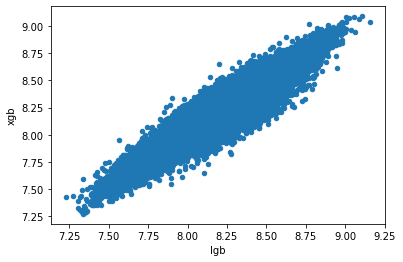

In [30]:
df_level2.plot.scatter(x="lgb", y="xgb");

### Blending: Mejores alphas por fold

In [11]:
best_alphas = []
alphas_to_try = np.linspace(0, 1, 1001)
blending_rmse = []
for fold in range(5):
    preds_lgb = df_level2[df_level2["kfold"] == fold]["lgb"].to_numpy()
    preds_xgb = df_level2[df_level2["kfold"] == fold]["xgb"].to_numpy()
    yvalid = df_level2[df_level2["kfold"] == fold]["target"].to_numpy()
    rmse_train_simple_mix = 1
    for alpha in alphas_to_try:
        mix = alpha*preds_lgb + (1-alpha)*preds_xgb
        rmse_mix = mean_squared_error(yvalid, mix, squared = False)
        if rmse_mix < rmse_train_simple_mix:
            best_alpha = alpha
            rmse_train_simple_mix = rmse_mix
    print('Best alpha: %f; Corresponding rmse score on train: %f' % (best_alpha, rmse_train_simple_mix))
    best_alphas.append(best_alpha)
    blending_rmse.append(rmse_train_simple_mix)
print("Mean rmse score:", np.mean(blending_rmse))

Best alpha: 0.542000; Corresponding rmse score on train: 0.717017
Best alpha: 0.386000; Corresponding rmse score on train: 0.717157
Best alpha: 0.375000; Corresponding rmse score on train: 0.719086
Best alpha: 0.515000; Corresponding rmse score on train: 0.718858
Best alpha: 0.511000; Corresponding rmse score on train: 0.717343
Mean rmse score: 0.7178921567110323


### Blending: Mejor alpha en general

In [46]:
alphas_to_try = np.linspace(0, 1, 1001)

preds_lgb = df_level2["lgb"].to_numpy()
preds_xgb = df_level2["xgb"].to_numpy()
yvalid = df_level2["target"].to_numpy()
rmse_train_simple_mix = 1
for alpha in alphas_to_try:
    mix = alpha*preds_lgb + (1-alpha)*preds_xgb
    rmse_mix = mean_squared_error(yvalid, mix, squared = False)
    if rmse_mix < rmse_train_simple_mix:
        best_alpha = alpha
        rmse_train_simple_mix = rmse_mix
print('Best alpha: %f; Corresponding rmse score on train: %f' % (best_alpha, rmse_train_simple_mix))

Best alpha: 0.468000; Corresponding rmse score on train: 0.717903


### En general: Optimización

Consideramos que nuestro dataset tiene $n$ datos y tenemos $m$ modelos.

$$\displaystyle\min \dfrac{1}{n} \sum_{i=1}^{n} (\hat y_i - y_i)^2 = \dfrac{1}{n}\sum_{i=1}^{n} \left(\sum_{j=1}^{m} (\alpha_j\hat y_i^j) - y_i \right)^2 $$
$$s.a \quad \sum_{j=1}^{m} \alpha_j = 1 $$
$$\alpha_j \ge 0 \quad \forall j \in \{1, \dotso, m\}$$

In [111]:
def combinacion_modelos(alphas, predictions):
    m = len(alphas)
    y_pred = np.sum(np.column_stack([alphas[i]*predictions[:, i] for i in range(m)]), axis = 1)
    return y_pred

def rmse_modelos(alphas, predictions, Y):
    y_pred = combinacion_modelos(alphas, predictions)
#     obj = np.sqrt(((y_pred - Y) ** 2).mean())
    obj = mean_squared_error(Y, y_pred, squared = False)
    return obj

m = 2 # cantidad de modelos
predictions = np.c_[preds_lgb, preds_xgb] # concatenacion de las predicciones
Y = yvalid # target

# initial value for alpha (guess)
# alphas = 1/m*np.ones_like(predictions[0,:]) # Entregarle el mismo peso a cada modelo como punto inicial
alphas = np.random.dirichlet(np.ones(2)) #asignar vector aleatorio con entradas que suman 1
print(alphas)

# alphas acotados por 0 y 1
A= np.eye(m)
lb= np.zeros(m)
ub= np.ones(m)
lin_cons1 =LinearConstraint(A,lb, ub)

# alphas suman 1
lin_cons2 =LinearConstraint(np.ones(m),1,1)

res = minimize(rmse_modelos, [alpha_0, alpha_1], args=(predictions, Y), tol=1e-10, constraints=[lin_cons1, lin_cons2])
print(res)

[0.62589478 0.37410522]
     fun: 0.717902540496462
     jac: array([0.00036242, 0.00036241])
 message: 'Optimization terminated successfully'
    nfev: 18
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.46759762, 0.53240238])


In [112]:
print(res.x)
print(sum(res.x))

[0.46759762 0.53240238]
1.0


Nuestro grid fue bastante bueno, sin embargo, esto es mucho más eficiente incluso para 2 modelos y mejor.

In [108]:
res.fun - rmse_train_simple_mix

-3.3418912082083807e-10

## Stacking

### Esquema Holdout

In [13]:
train_meta = df_level2[df_level2["kfold"].le(3)].drop(columns = "kfold")
test_meta = df_level2[df_level2["kfold"].ge(4)].drop(columns = "kfold")
y_train = train_meta.pop("target")
y_test = test_meta.pop("target")

In [14]:
model_xgb = XGBRegressor(**xgb_params, random_state = 0)
model_xgb.fit(train_meta, y_train, verbose=False,
              eval_set=[(test_meta, y_test)],
              eval_metric="rmse",
              early_stopping_rounds=1000
              )
preds_xgb= model_xgb.predict(test_meta, ntree_limit = model_xgb.get_booster().best_ntree_limit)
rmse = mean_squared_error(y_test, preds_xgb, squared=False)
print("rmse:", rmse)

rmse: 0.7171440630022933


Podemos usar también regresión lineal o el modelo que nosotros estimemos conveniente.

In [28]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_meta, y_train)
preds_lin = reg.predict(test_meta)
print("rmse:", mean_squared_error(y_test, preds_lin, squared=False))

rmse: 0.7173701914246885


Entrenar en la totalidad

In [15]:
model_xgb = XGBRegressor(**xgb_params, random_state = 0)
model_xgb.fit(df_level2.drop(columns = ["target", "kfold"]), df_level2["target"], 
              verbose=False,
              eval_metric="rmse"
              )

XGBRegressor(alpha=0.31497378201113674, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.182752418577295, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             lambda=0.08413322850225624, learning_rate=0.09344238585504369,
             max_delta_step=0, max_depth=2, min_child_weight=148.2986978620488,
             missing=nan, monotone_constraints='()', n_estimators=20000,
             n_jobs=16, num_parallel_tree=1, predictor='gpu_predictor',
             random_state=0, reg_alpha=0.314973772, reg_lambda=0.0841332301,
             scale_pos_weight=1, subsample=0.5105633202654916,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

Predecir en test set (debemos tener un test set de nivel 2 con las meta features)

In [23]:
lgb_preds =  np.mean(np.column_stack(final_predictions_lgb), axis = 1)
xgb_preds = np.mean(np.column_stack(final_predictions_xgb), axis = 1)
df_final = pd.DataFrame(np.c_[lgb_preds, xgb_preds], columns = ["lgb", "xgb"])
df_final_preds = model_xgb.predict(df_final)

In [26]:
sample_submission["target"] = df_final_preds

In [25]:
df_final_preds

array([8.131369, 8.403622, 8.409484, ..., 8.498569, 8.282507, 7.907166],
      dtype=float32)

LB score : 0.71931

In [27]:
# sample_submission.to_csv("output/submission_basic_stacking.csv", index=False)